# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### CONSTRUÇÃO DE UM MODELO PARA PREVER PREÇOS DE IMÓVEIS MÉDIOS, ANUNCIADOS NA PLATAFORMA AIRBNB NA CIDADE DO RIO DE JANEIRO
    
    O objetivo do presente código é prever apenas os preços dos imóveis de valor médio, fugindo do escopo dos imóveis de luxo a fim de dar mais especifidade/assertividade ao modelo de predição. 
    
    Para o tanto, utilizaremos as bibliotecas abaixo e trataremos a base de dados, dispensando as features desnecessárias, e utilizando featuring engineering para outras.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd 
import pathlib 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split



Para cada arquivo da base de dados, iremos importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr':4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# Nossos arquivos encontram-se na pasta "dataset"

caminho = pathlib.Path('dataset')

dataframes = []

bases_airbnb = pd.DataFrame()

for arquivo in caminho.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(arquivo, low_memory=False)
    df['ano'] = ano 
    df['mes'] = mes
    dataframes.append(df)
    
bases_airbnb = pd.concat(dataframes)
display(bases_airbnb)



id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

In [3]:
# SELECIONANDO APENAS COLUNAS RELEVANTES PARA A CONSTRUÇÃO DO MODELO

colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

bases_airbnb = bases_airbnb.loc[:, colunas]
display(bases_airbnb.head())


host_response_time host_response_rate host_is_superhost  \
0                NaN                NaN                 f   
1     within an hour               100%                 t   
2     within an hour               100%                 f   
3     within an hour               100%                 f   
4     within an hour               100%                 t   

   host_listings_count   latitude  longitude property_type        room_type  \
0                  1.0 -22.946854 -43.182737     Apartment  Entire home/apt   
1                  2.0 -22.965919 -43.178962   Condominium  Entire home/apt   
2                  1.0 -22.985698 -43.201935     Apartment  Entire home/apt   
3                  3.0 -22.977117 -43.190454     Apartment  Entire home/apt   
4                  1.0 -22.983024 -43.214270     Apartment  Entire home/apt   

   accommodates  bathrooms  ...  review_scores_cleanliness  \
0             4        1.0  ...                        9.0   
1             5        1.0  ...                        9.0   
2             2        1.0  ...                       10.0   
3             3        1.0  ...                       10.0   
4             3        1.0  ...                       10.0   

   review_scores_checkin review_scores_communication review_scores_location  \
0                    9.0                         9.0                    9.0   
1                   10.0                        10.0                    9.0   
2                   10.0                        10.0                   10.0   
3                   10.0                        10.0                   10.0   
4                   10.0                        10.0                   10.0   

  review_scores_value instant_bookable is_business_travel_ready  \
0                 9.0                f                        f   
1                 9.0                t                        f   
2                 9.0                f                        f   
3                 9.0                f                        f   
4                 9.0                t                        f   

           cancellation_policy   ano  mes  
0  strict_14_with_grace_period  2018    4  
1                       strict  2018    4  
2                       strict  2018    4  
3                       strict  2018    4  
4                       strict  2018    4  

[5 rows x 34 columns]

In [4]:
# VERIFICANDO NÚMERO DE LINHAS NULAS

print(bases_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [5]:
# EXCLUINDO COLUNAS COM GRANDE NÚMERO DE LINHAS NULAS PARA NÃO ENVIEZAR O MODELO

for coluna in bases_airbnb:
    if bases_airbnb[coluna].isnull().sum() > 300000:
        bases_airbnb = bases_airbnb.drop(coluna, axis=1)
print(bases_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [6]:
# excluindo linhas nulas, já que, hipoteticamente não apresentarão problemas, devido ao grande número de dados disponíveis

bases_airbnb = bases_airbnb.dropna()
bases_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  object 
 13  guests_included           897709 non-null  int64  

In [7]:
# verificando os tipos dos dados das colunas para eventual correção

print(bases_airbnb.dtypes)
print('-'*60)
print(bases_airbnb.iloc[0])


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

In [8]:
# price está no formato object, necessário mudar para float, já que trata-se de um valor monetário
# extra_preople está no formato object, necessário mudar para float, já que trata-se de um valor monetário
# para o tanto é necessário excluir o $ e substituir a vírgula, para adaptar a leitura ao Python 

bases_airbnb['price'] = bases_airbnb['price'].str.replace('$', '')
bases_airbnb['price'] = bases_airbnb['price'].str.replace(',', '')

bases_airbnb['extra_people'] = bases_airbnb['extra_people'].str.replace('$', '')
bases_airbnb['extra_people'] = bases_airbnb['extra_people'].str.replace(',', '')


# conferindo a conversao das strings para converter em float

print(bases_airbnb.iloc[1])

host_is_superhost                                                           t
host_listings_count                                                       2.0
latitude                                                           -22.965919
longitude                                                          -43.178962
property_type                                                     Condominium
room_type                                                     Entire home/apt
accommodates                                                                5
bathrooms                                                                 1.0
bedrooms                                                                  2.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,"Cable TV",Internet,Wifi,"Air conditioning...
price                                                           

In [9]:
# checando colunas adicionais
print(bases_airbnb['instant_bookable'].value_counts())
print(bases_airbnb['instant_bookable'].dtype)

print(bases_airbnb['is_business_travel_ready'].value_counts())
print(bases_airbnb['is_business_travel_ready'].dtype)


instant_bookable
f    553661
t    344048
Name: count, dtype: int64
object
is_business_travel_ready
f    897709
Name: count, dtype: int64
object


In [10]:
# como a coluna is_business_travel_ready apresenta apenas um valor, ela pode ser deletada sem problemas.

bases_airbnb = bases_airbnb.drop('is_business_travel_ready', axis=1)


In [11]:
# transformando object em float nas colunas extra_preople e price para númericas utilizando a função astype do numpy

bases_airbnb['price'] = bases_airbnb['price'].astype(np.float32, copy=False)
bases_airbnb['extra_people'] = bases_airbnb['extra_people'].astype(np.float32, copy=False)

# transformando f e t das colunas instant_bookable, e is_business_travel_ready em inteiros, 1 e 0   

print(bases_airbnb.dtypes)
print('-'*60)
print(bases_airbnb.iloc[1])



host_is_superhost       object
host_listings_count    float64
latitude               float64
longitude              float64
property_type           object
room_type               object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                object
amenities               object
price                  float32
guests_included          int64
extra_people           float32
minimum_nights           int64
maximum_nights           int64
number_of_reviews        int64
instant_bookable        object
cancellation_policy     object
ano                      int64
mes                      int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                      t
host_listings_count                                                  2.0
latitude                                                      -22.965919
longitude               

### Identificando Correlação estatística entre as colunas, e descobrindo os pares com threshold superior a 0.9

<Axes: >

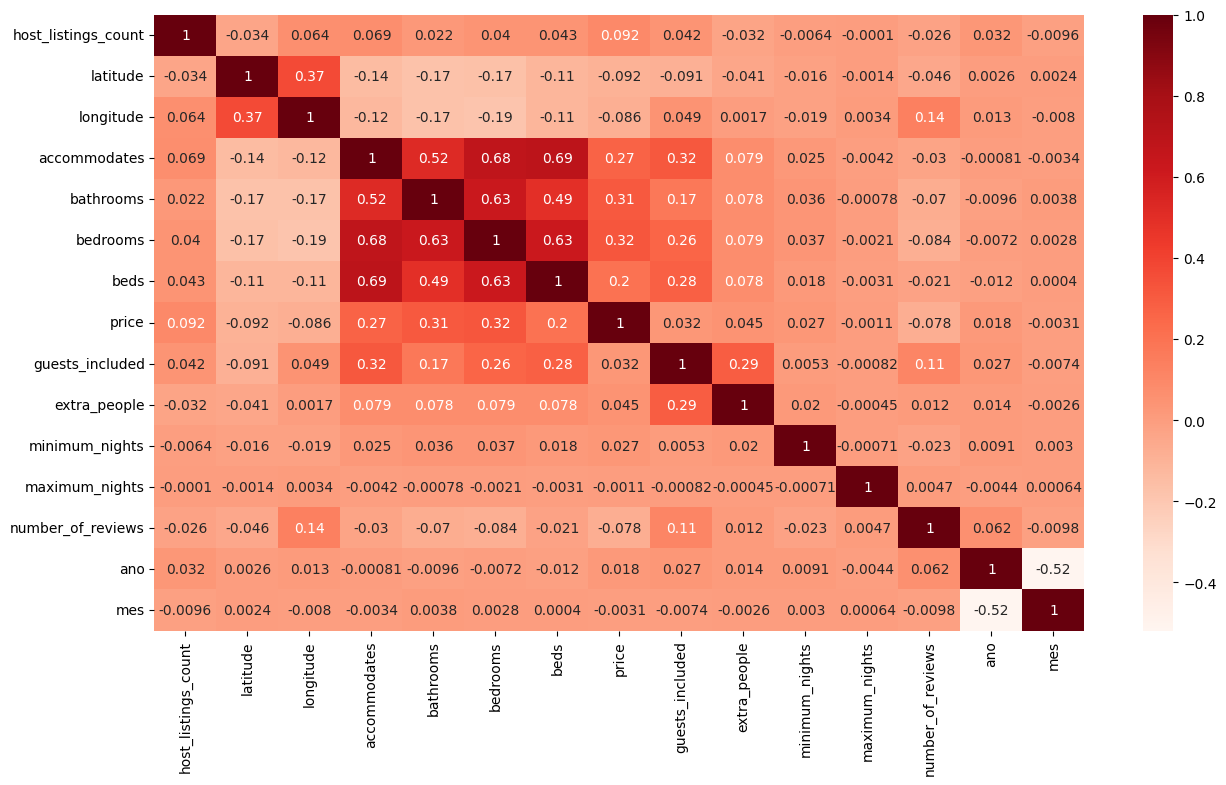

In [12]:
# selecionando apenas colunas numericas e descobrindo correlação e as plotando em um heatmap 

correlation_matrix = bases_airbnb.corr(numeric_only=True)

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')

In [13]:
# checando se há correlação com threshold maior que 0.92

corr_matrix_df = pd.DataFrame(correlation_matrix)
for col1 in corr_matrix_df.columns:
    for col2 in corr_matrix_df.index:
        valor = corr_matrix_df.loc[col1, col2]
        if col1 != col2 and valor > 0.92:
            print(f"Correlação alta entre {col1} e {col2}: {valor}")
else:
    print('não há correlação maior que o threshould de 0.92')


não há correlação maior que o threshould de 0.92


In [14]:
# calculando outliers, lembrando que a amplitude é o 3º quartil - 1º quartel
# o limite inferior é q1 - 1.5 * amplitude 
# o limite superior é q1 + 1.5 * amplitude

def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1 
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [15]:
### definindo função para excluir outliers

def remover_limites(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas

In [16]:
### função para definir plot de gráfico de histograma de caixa

def boxhist(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    paleta = sns.color_palette("pastel")
    sns.boxplot(x=coluna, ax=ax1, color=paleta[3])
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2, color=paleta[3])


In [17]:
### função para definir plot de gráfico de histograma

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    paleta = sns.color_palette("flare")
    sns.histplot(coluna, kde=True, color=paleta[5])
    plt.show()

In [18]:
def barplot(coluna):
     plt.figure(figsize=(15, 5))
     paleta = sns.color_palette("rocket")

     # utiliza-se o "ax" que é o output da função barplot conforme a biblioteca do sns disponível no site 
     # [https://seaborn.pydata.org/generated/seaborn.barplot.html]
    
     ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), hue=coluna.value_counts().index, palette=paleta, legend=False)

     # atribuindo limites com a função anteriormente criada, para melhorar a visualização do gráfico,
     ax = ax.set_xlim(limites(coluna))
     plt.show()

In [19]:
# função para definir plot de gráfico de barra

#
def colors_from_values(values, palette_name):

    ##
    normalized = (values - min(values)) / (max(values) - min(values)) 
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return list(np.array(palette).take(indices, axis=0)) 

def barplot(coluna):
    plt.figure(figsize=(15, 5))
    paleta = colors_from_values(coluna.value_counts(), "rocket_r")

    # utiliza-se o "ax" que é o output da função barplot conforme a biblioteca do sns disponível no site 
    # [https://seaborn.pydata.org/generated/seaborn.barplot.html]

    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), hue=coluna.value_counts().index, palette=paleta, legend=False)
    ax = ax.set_xlim(limites(coluna))  
    
    plt.show()
   

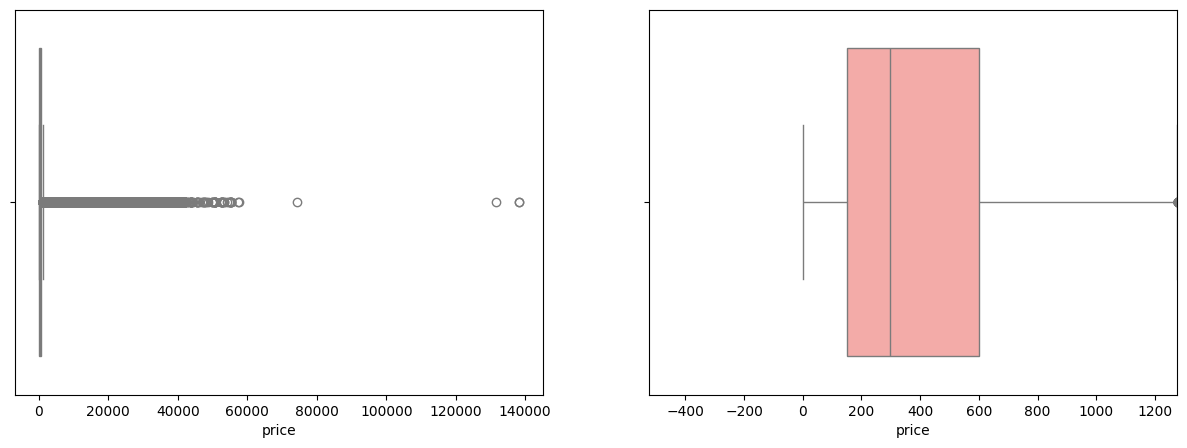

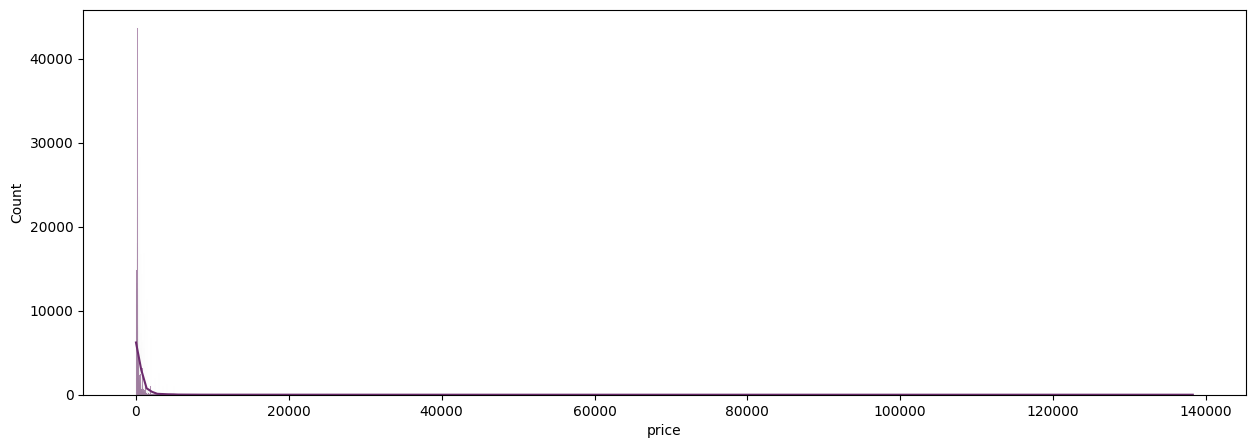

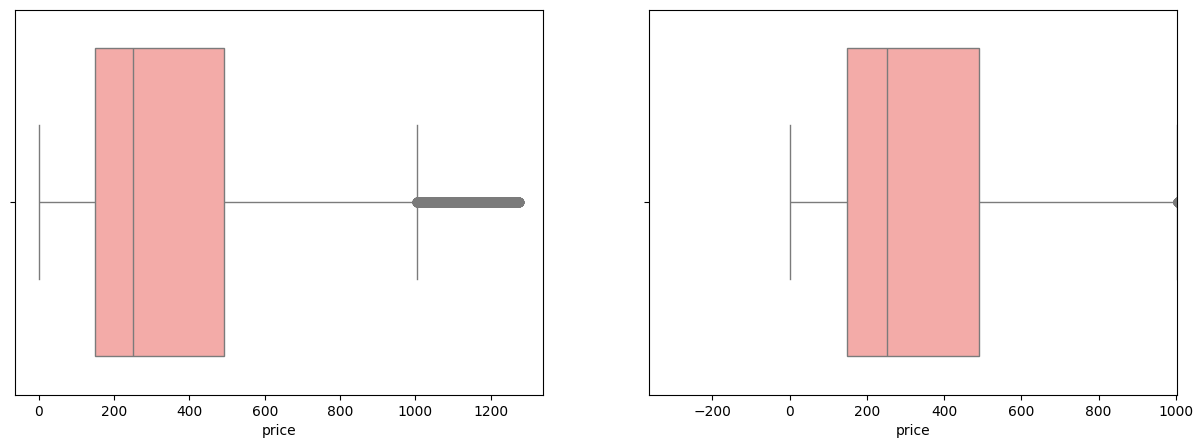

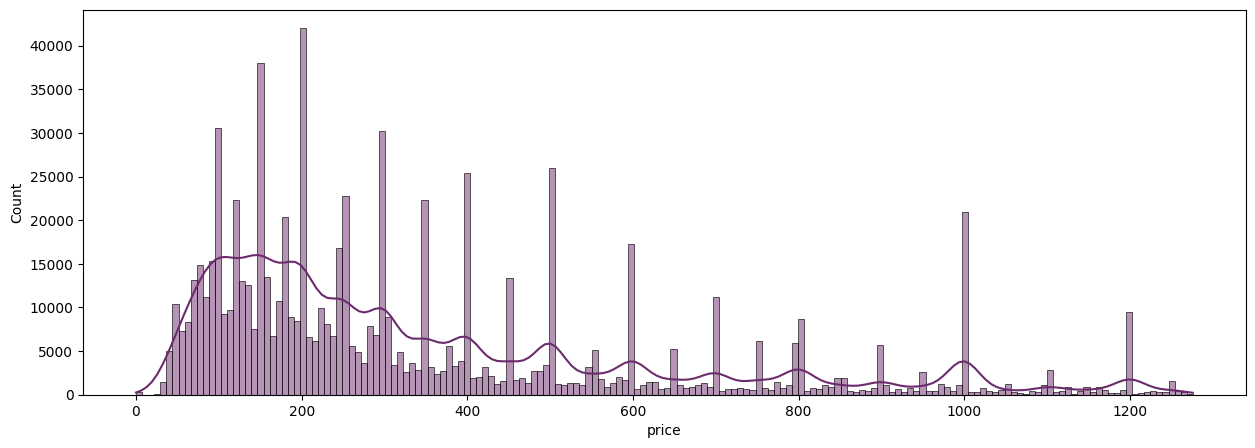

In [20]:
# ANALISANDO COLUNA DE PREÇOS C/ OUTLIERS

boxhist(bases_airbnb['price'])
histograma(bases_airbnb['price'])

# aplicando a função para excluir os outliers inferiores e superiores 

bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'price')

# plotando o gráfico de histograma, agora com S/ OUTLIERS 

boxhist(bases_airbnb['price'])
histograma(bases_airbnb['price'])

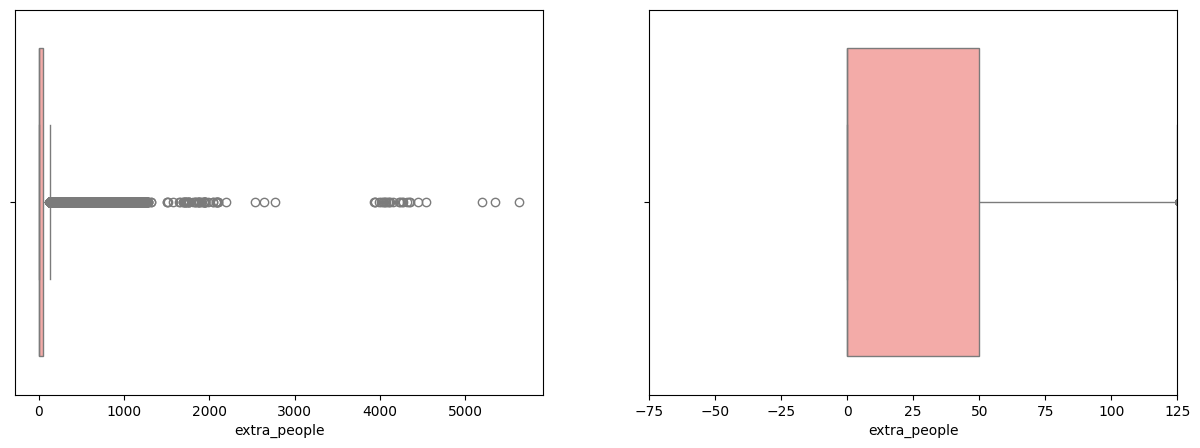

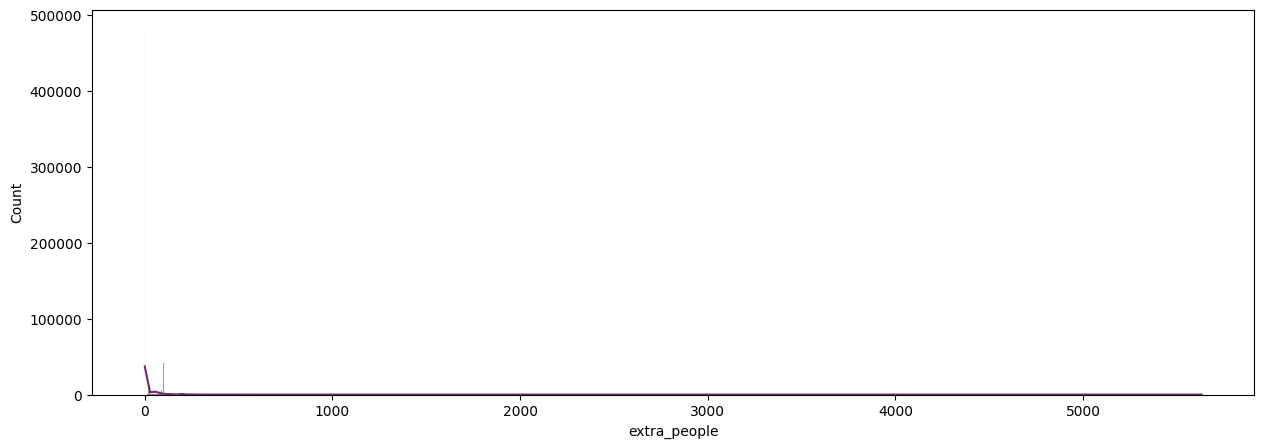

59194 linhas removidas


In [21]:
# ANALISANDO COLUNA DE EXTRA_PEOPLE (valor adicional por número de hóspedes)

boxhist(bases_airbnb['extra_people'])
histograma(bases_airbnb['extra_people'])

# aplicando a função para excluir os outliers inferiores e superiores

bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

# IMPORTANTE TESTAR O MODELO C/ E S/ OUTLIERS E REVER O SCORE




In [22]:
bases_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 751233 entries, 0 to 34328
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   host_is_superhost    751233 non-null  object 
 1   host_listings_count  751233 non-null  float64
 2   latitude             751233 non-null  float64
 3   longitude            751233 non-null  float64
 4   property_type        751233 non-null  object 
 5   room_type            751233 non-null  object 
 6   accommodates         751233 non-null  int64  
 7   bathrooms            751233 non-null  float64
 8   bedrooms             751233 non-null  float64
 9   beds                 751233 non-null  float64
 10  bed_type             751233 non-null  object 
 11  amenities            751233 non-null  object 
 12  price                751233 non-null  float32
 13  guests_included      751233 non-null  int64  
 14  extra_people         751233 non-null  float32
 15  minimum_nights       75

### ANALISANDO COLUNAS QUE NÃO SÃO OBJETCS e possuem valor preditivo, quais sejam: 
 host_listings_count         
 accommodates       
 bathrooms            
 bedrooms             
 beds                 
 price    
 guests_included                  
 extra_people         
 minimum_nights       
 maximum_nights       
 number_of_reviews    
 instant_bookable     


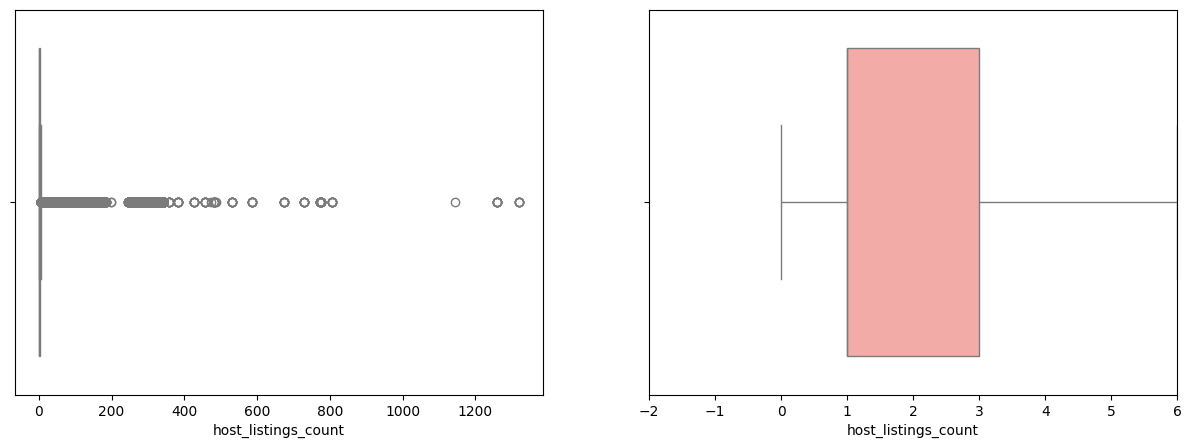

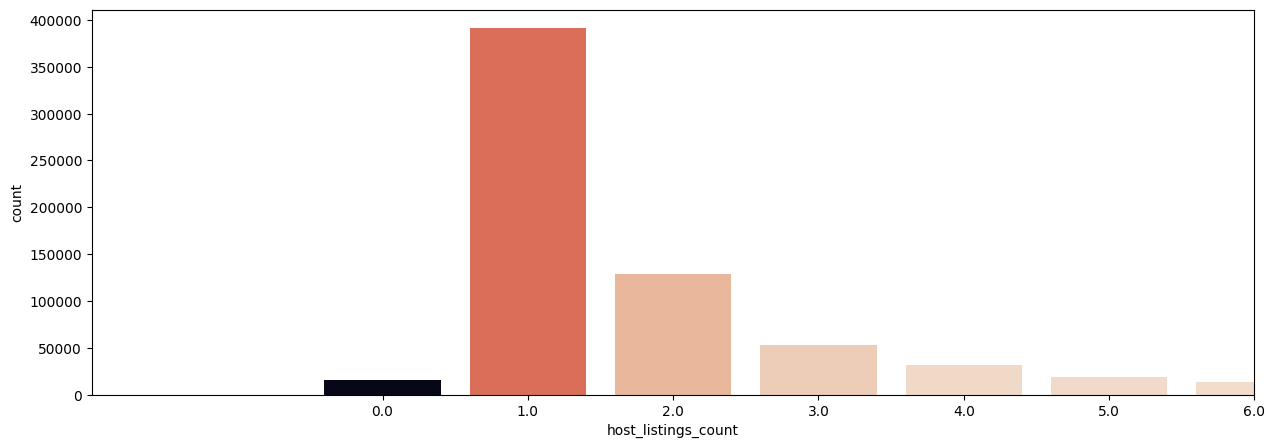

In [23]:
boxhist(bases_airbnb['host_listings_count'])
barplot(bases_airbnb['host_listings_count'])

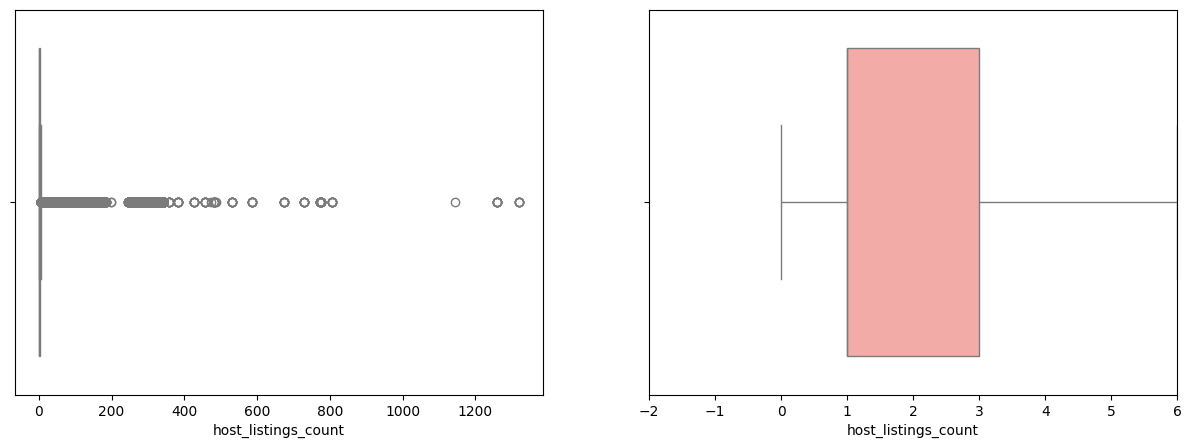

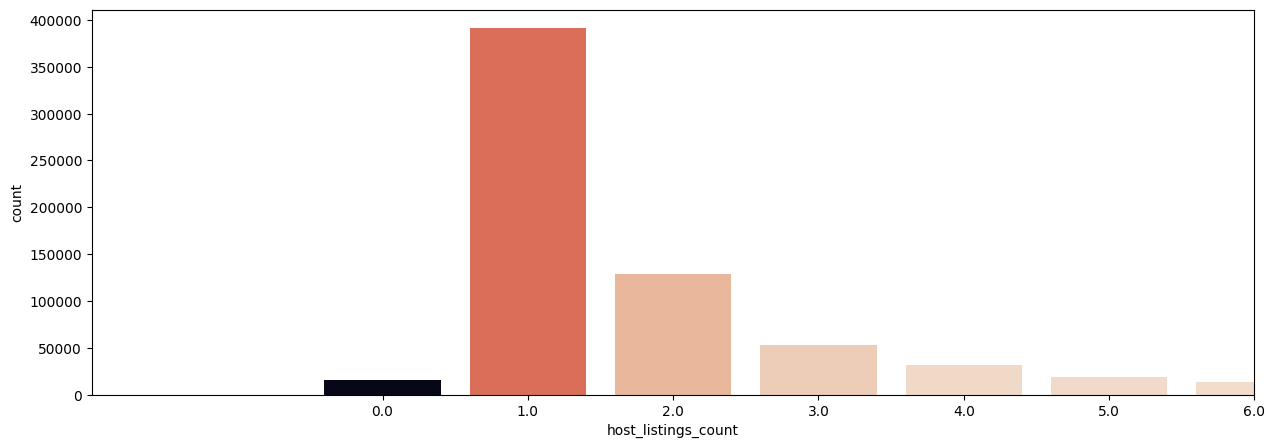

In [24]:
# no caso supra, será necessário atribuir limites na função do gráfico de barras, para diminuir os valores exibidos e poder fazer a análise 
# adicionamos na função de barras a função para atribuir limites
boxhist(bases_airbnb['host_listings_count'])
barplot(bases_airbnb['host_listings_count'])

In [25]:
# agora excluiremos os outliers com a função anteriormente criada para fazermos a análise sem
bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))


97723 linhas removidas


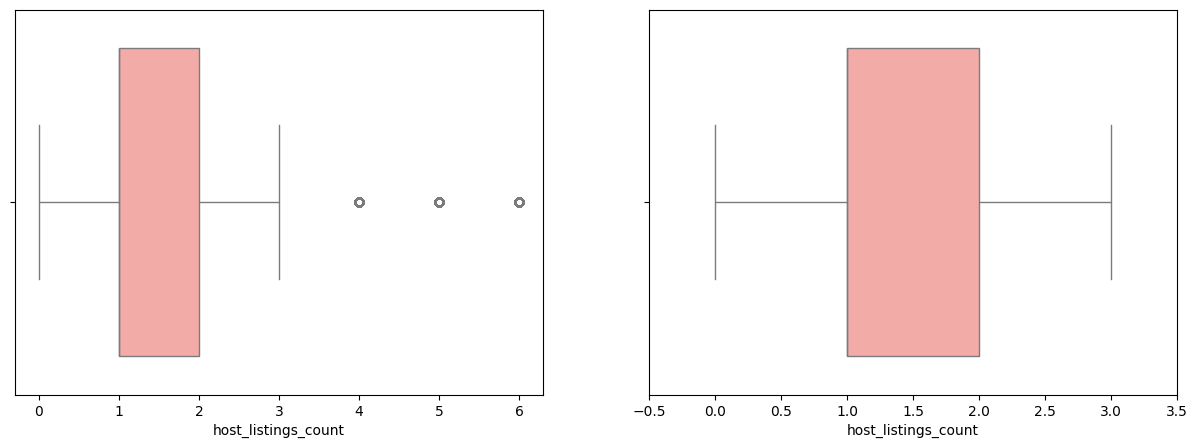

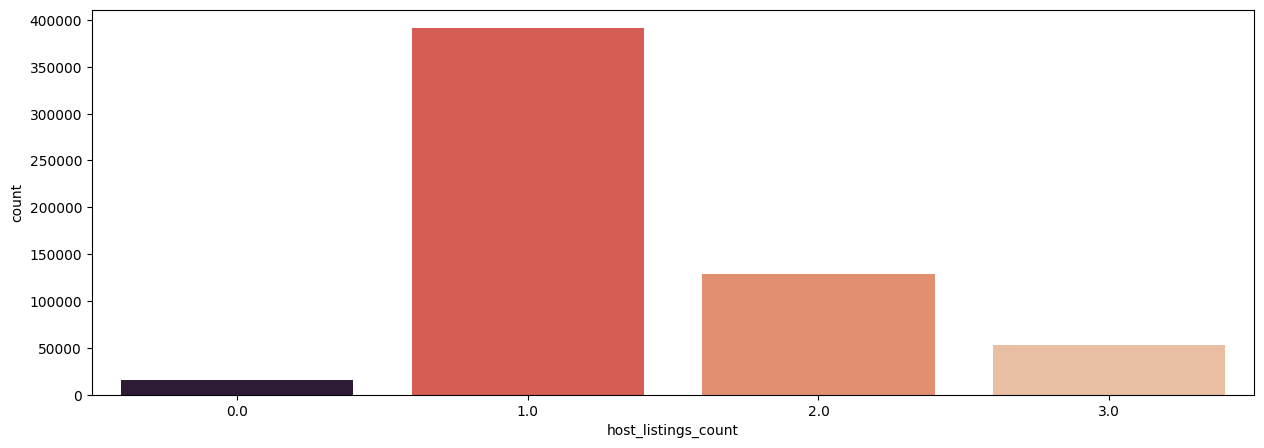

In [26]:
boxhist(bases_airbnb['host_listings_count'])
barplot(bases_airbnb['host_listings_count'])

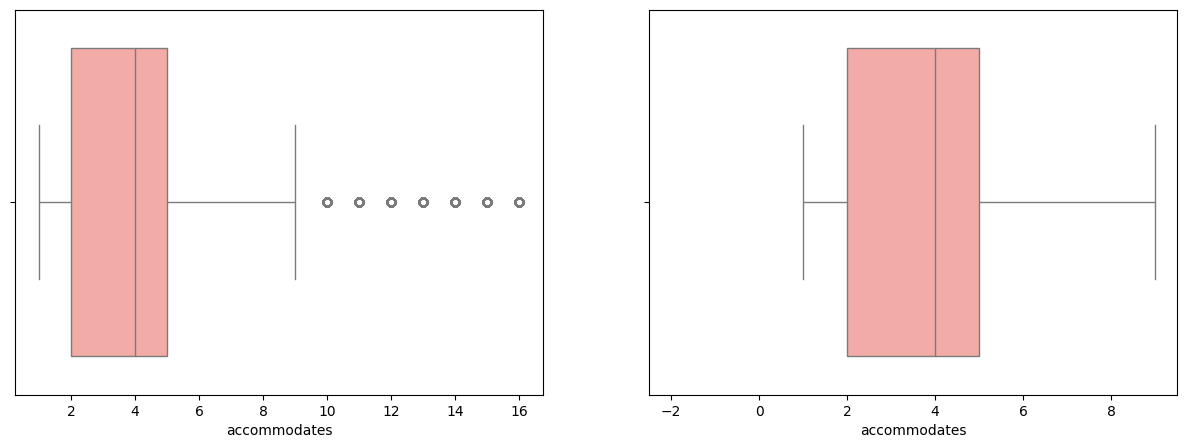

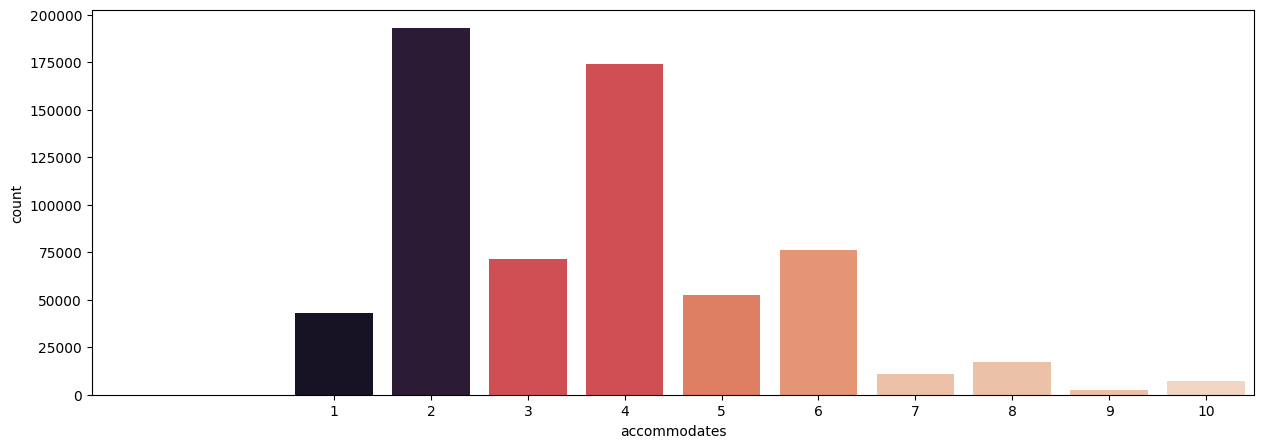

In [27]:
# plotando gráficos da coluna 'acommodates" que refere o número de cômodos do imóvel 
boxhist(bases_airbnb['accommodates'])
barplot(bases_airbnb['accommodates'])

In [28]:
# extrai-se do gráfico acima, que a coluna Acommodates possui poucos outliers, cuja exclusão não implicará em prejuízo para o modelo. 
# vamos utilizar a função para excluir os outliers fora dos limites

bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


<Axes: xlabel='bathrooms', ylabel='count'>

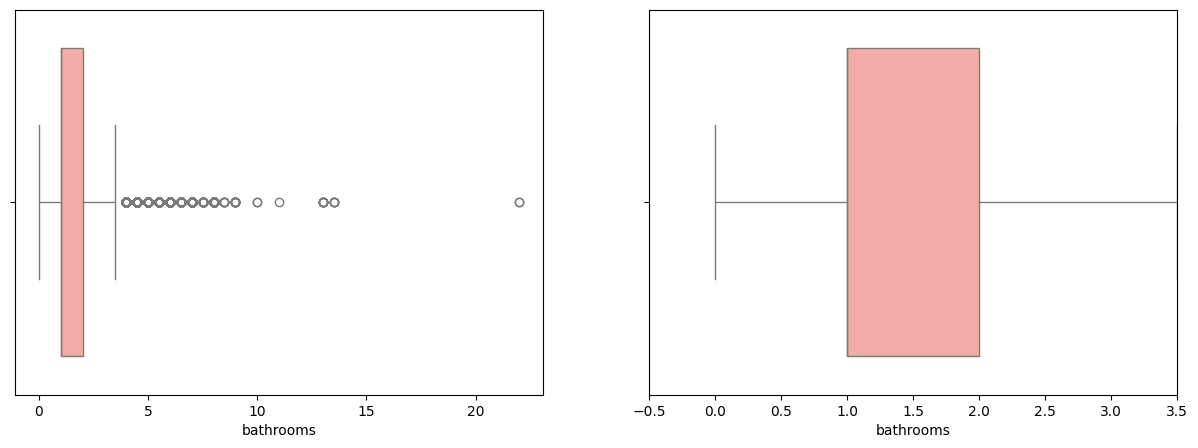

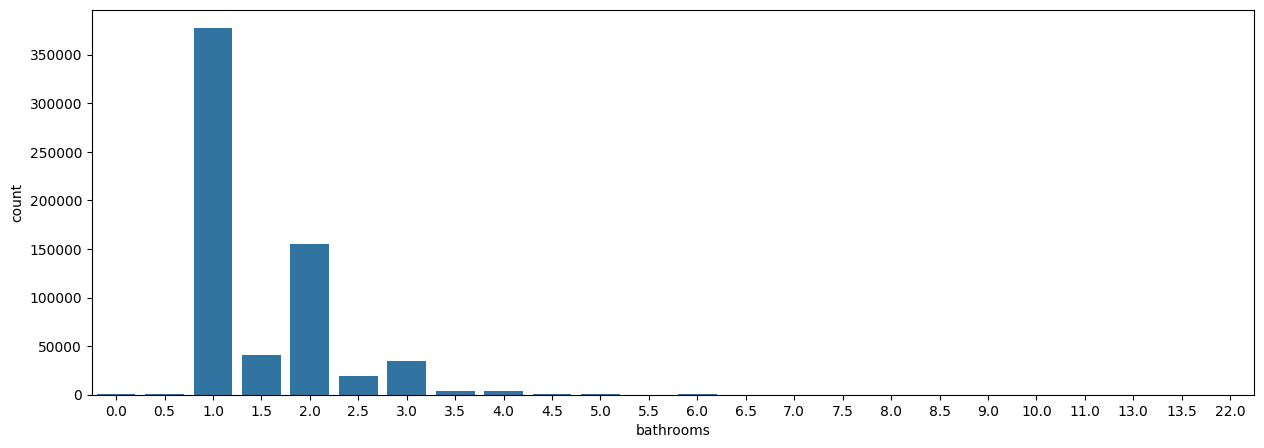

In [29]:
### plotando gráficos da coluna 'bathrooms" que refere o número de banheiros do imóvel 
boxhist(bases_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=bases_airbnb['bathrooms'].value_counts().index, y=bases_airbnb['bathrooms'].value_counts())


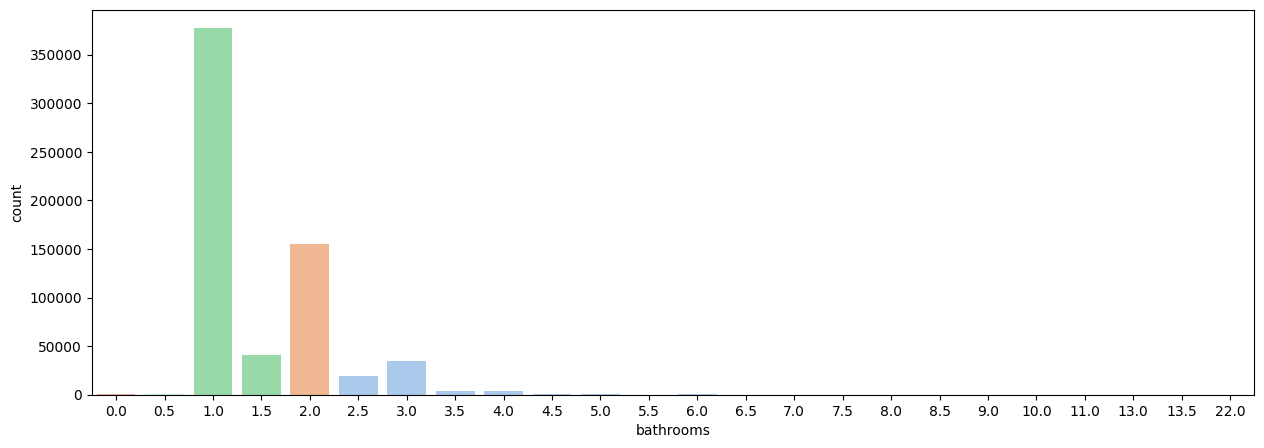

In [30]:
# tratando o eixo X do gráfico de barras para que exiba corretamente os limites do número de banheiros
plt.figure(figsize=(15, 5))
cor_bathroom = colors_from_values(bases_airbnb['bathrooms'].value_counts(), "pastel")
sns.barplot(x=bases_airbnb['bathrooms'].value_counts().index, y=bases_airbnb['bathrooms'].value_counts(), hue=bases_airbnb['bathrooms'].value_counts().index, palette=cor_bathroom, legend=False)
plt.show()

In [31]:
# pode-se concluir que é seguro excluir outliers da coluna bathroons, devido ao número irrelevantes destes
bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))


6894 linhas removidas


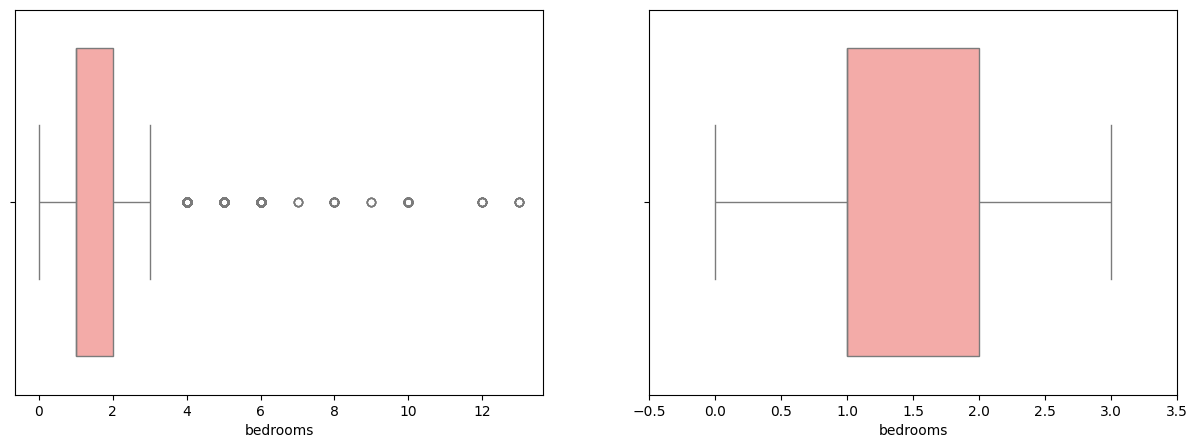

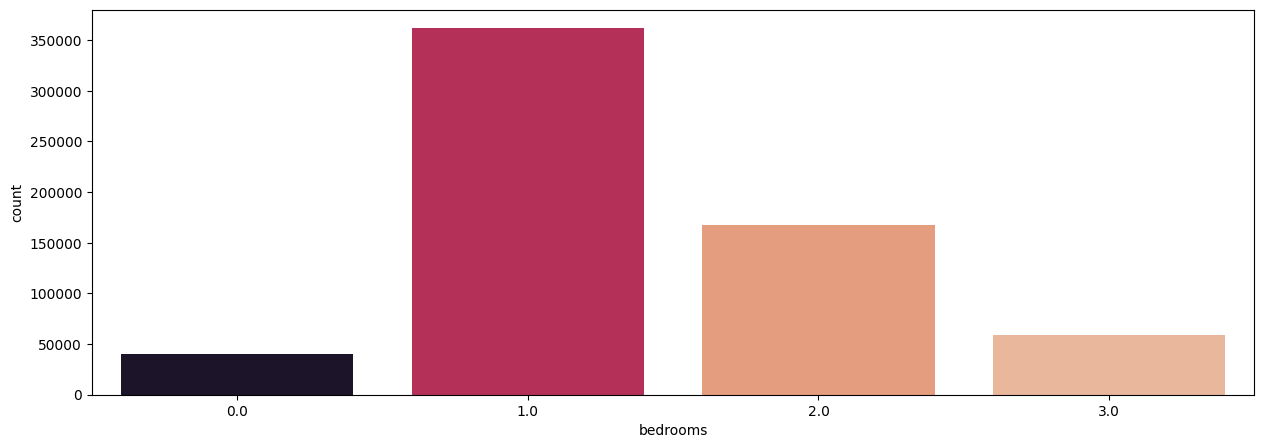

In [32]:
# plotando gráficos da coluna 'bedrooms" que refere o número de camas do imóvel 
boxhist(bases_airbnb['bedrooms'])
barplot(bases_airbnb['bedrooms'])


In [33]:
# pode-se concluir que é seguro excluir outliers da coluna bedrooms, devido ao número irrelevantes destes
bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


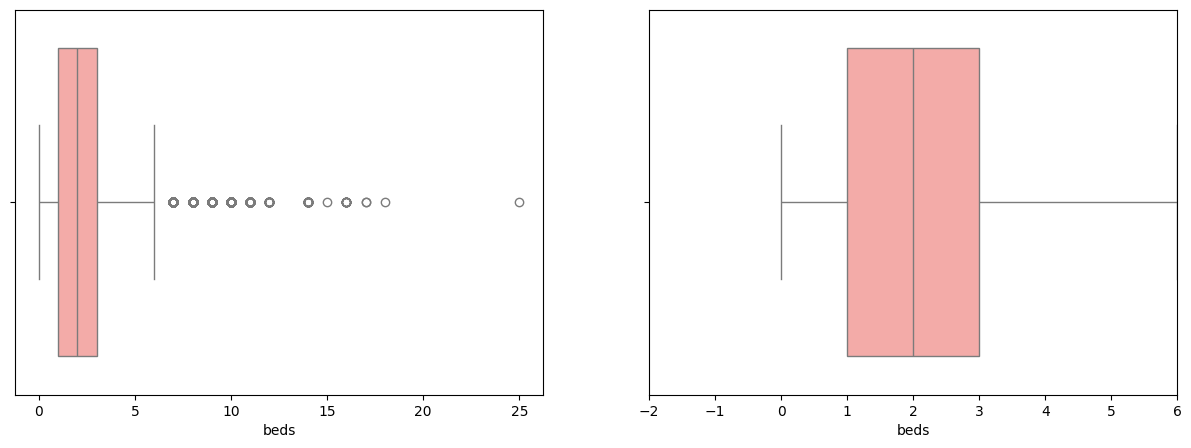

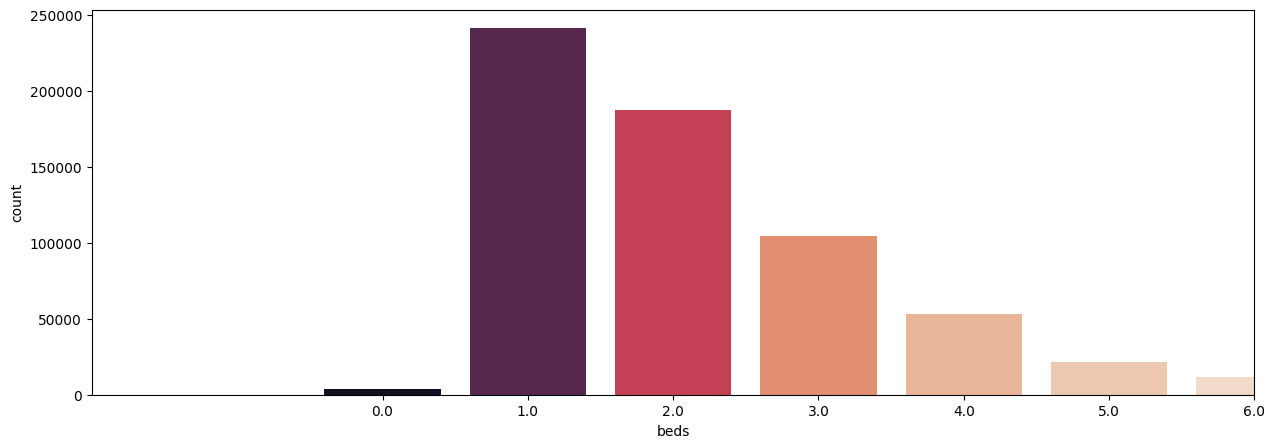

In [34]:
# plotando gráficos da coluna 'beds" que refere o número de camas do imóvel 
boxhist(bases_airbnb['beds'])
barplot(bases_airbnb['beds'])

In [35]:
# pode-se concluir que é seguro excluir outliers da coluna beds, devido ao número irrelevantes destes
bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


(1.0, 1.0)


C:\Users\Marcio\AppData\Local\Temp\ipykernel_38324\435801527.py:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Marcio\AppData\Local\Temp\ipykernel_38324\632239685.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax = ax.set_xlim(limites(coluna))


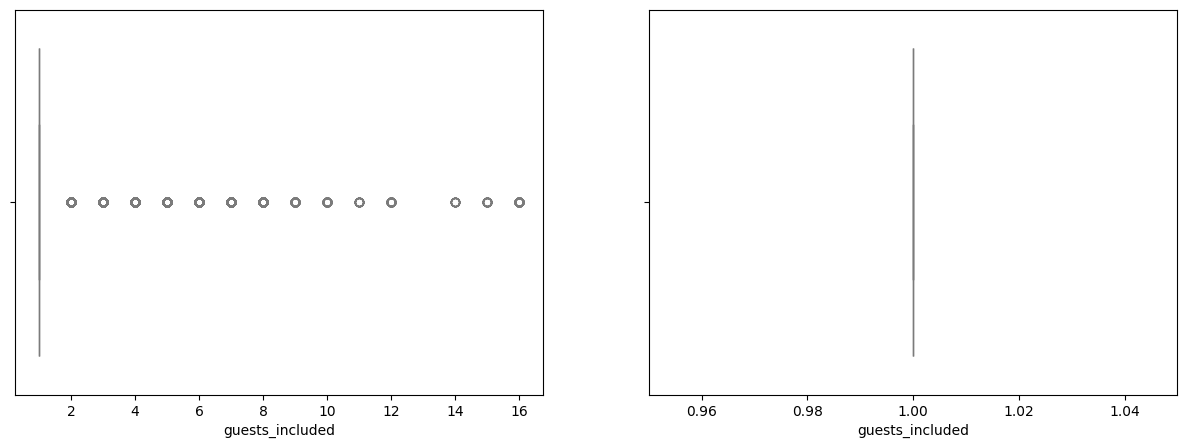

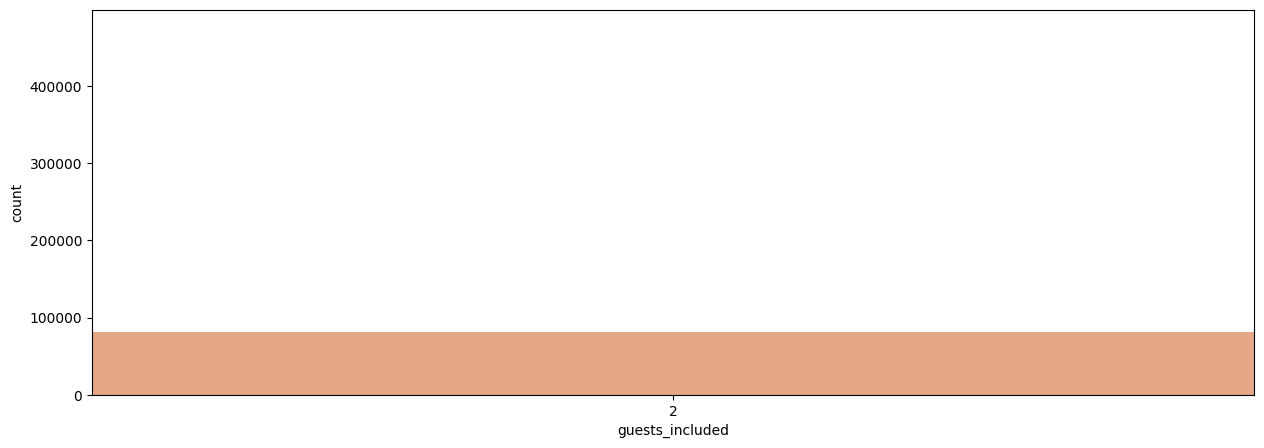

In [36]:
# plotando gráficos da coluna 'guests_included" que refere o número de hóspedes que estão incluídos na locação.
print(limites(bases_airbnb['guests_included']))
boxhist(bases_airbnb['guests_included'])
barplot(bases_airbnb['guests_included'])

In [37]:
# Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. 
# Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço,
# por isso, me parece melhor excluir a coluna da análise

bases_airbnb = bases_airbnb.drop('guests_included', axis=1)
bases_airbnb.shape

(622366, 21)

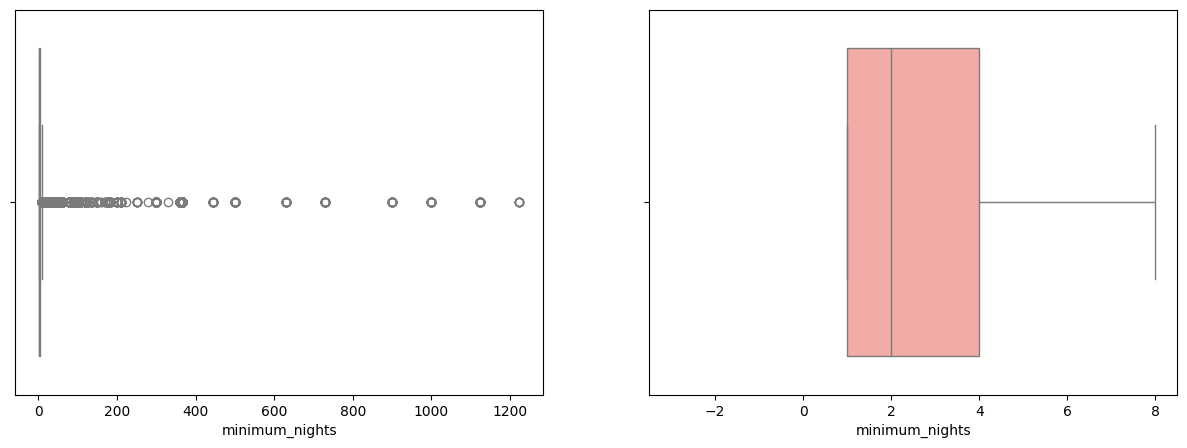

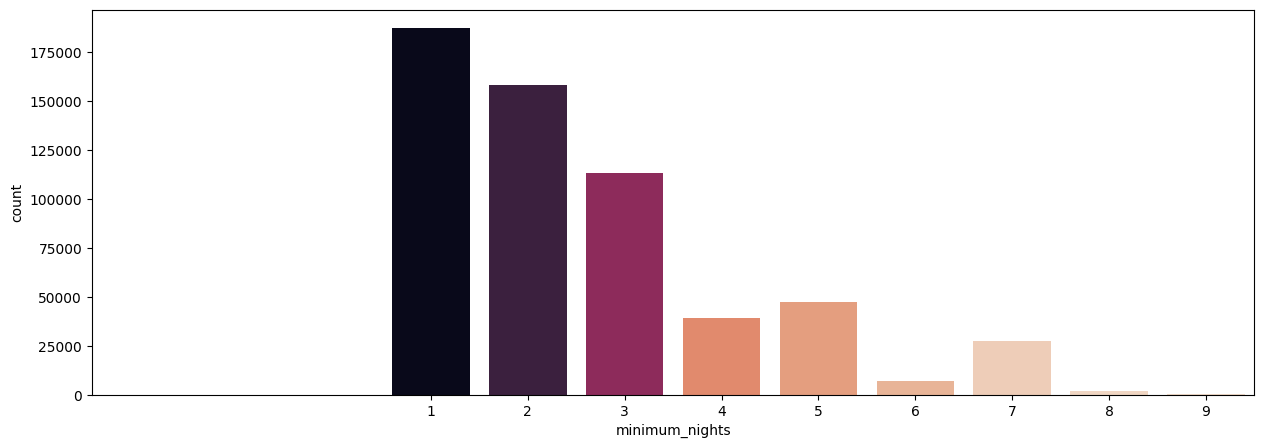

40383 linhas removidas


In [38]:
# plotando gráficos da coluna "minimum_nights" que refere o número mínimo de noites para locação 

boxhist(bases_airbnb['minimum_nights'])
barplot(bases_airbnb['minimum_nights'])

# pode-se concluir que é seguro excluir outliers da coluna beds, devido ao número irrelevantes destes

bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

(-1612.5, 2767.5)


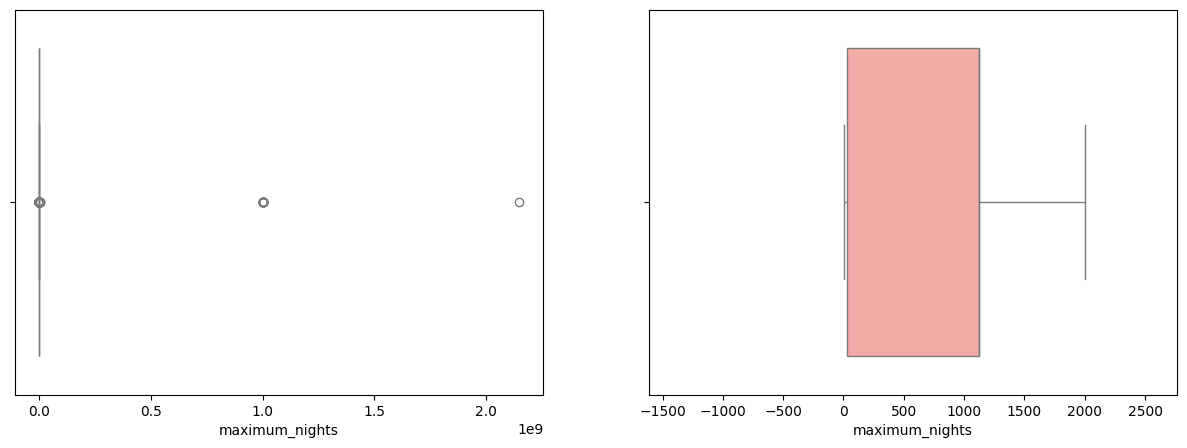

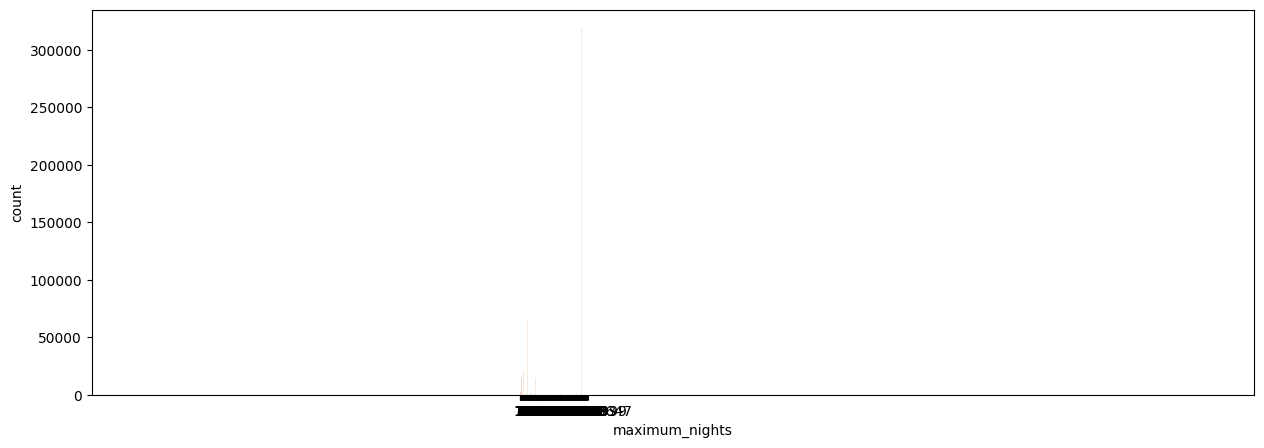

número de linhas restantes: 581983, número de colunas restantes: 20


In [39]:
# plotando gráficos da coluna "maximum_nights" que refere o número máximo de noites para locação 

print(limites(bases_airbnb['maximum_nights']))
boxhist(bases_airbnb['maximum_nights'])
barplot(bases_airbnb['maximum_nights'])

# extrai-se do output que os limites estão em números exorbitantes,
# e que muito provavelmente foram preenchidos de forma errônea, e poderão prejudicar nosso modelo
# vamos dropar essa feature:

bases_airbnb = bases_airbnb.drop('maximum_nights', axis=1)
print(f'número de linhas restantes: {bases_airbnb.shape[0]}, número de colunas restantes: {bases_airbnb.shape[1]}')



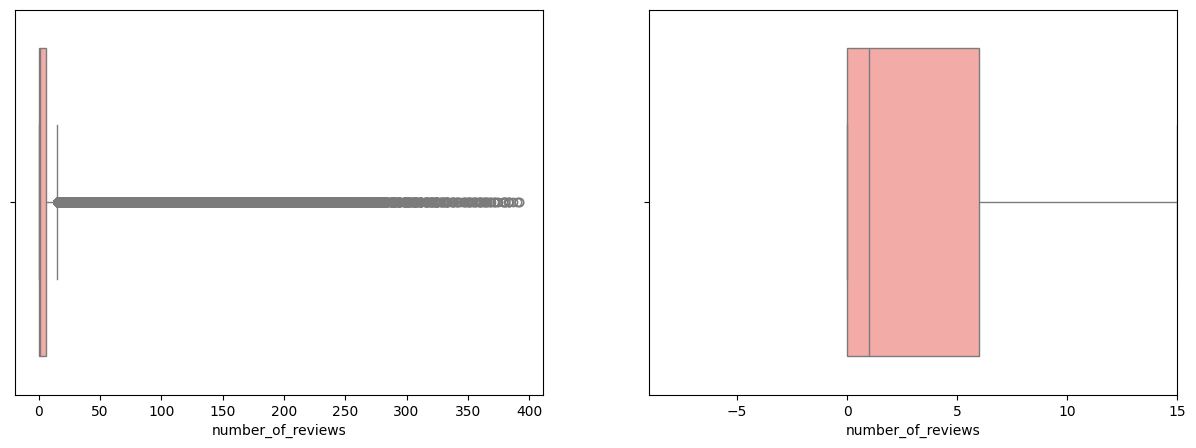

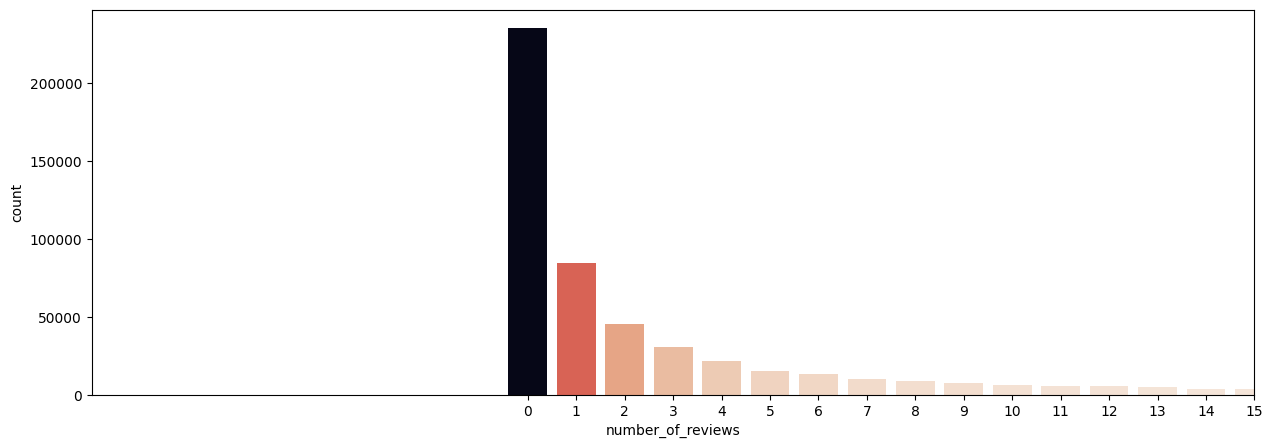

In [40]:
# plotando gráficos da coluna 'number_of_reviews' que refere o número de avaliações dos clientes  

boxhist(bases_airbnb['number_of_reviews'])
barplot(bases_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [41]:
# optando por droppar a feature, sujeito a teste com ela inclusa, posteriormente.

basse_airbnb = bases_airbnb.drop('number_of_reviews', axis=1)
print(f'número de linhas restantes: {bases_airbnb.shape[0]}, número de colunas restantes: {bases_airbnb.shape[1]}')

número de linhas restantes: 581983, número de colunas restantes: 20


In [42]:
# Tratamento de Colunas de Valores de Texto 'property_type'
print(bases_airbnb['property_type'].value_counts())

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

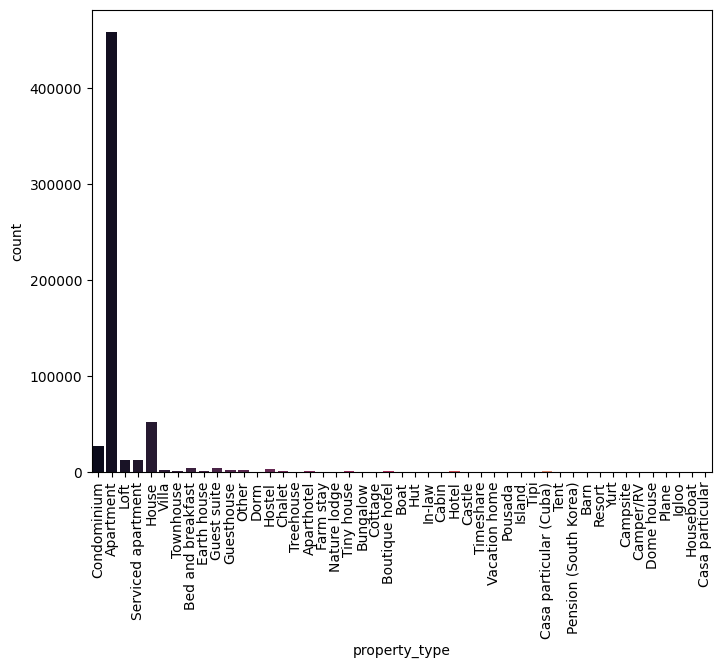

In [43]:
plt.figure(figsize=(8, 6))
grafico = sns.countplot(x='property_type', data=bases_airbnb, hue='property_type', palette='rocket')
grafico.tick_params(axis='x', rotation=90)
plt.show()

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Other                   8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


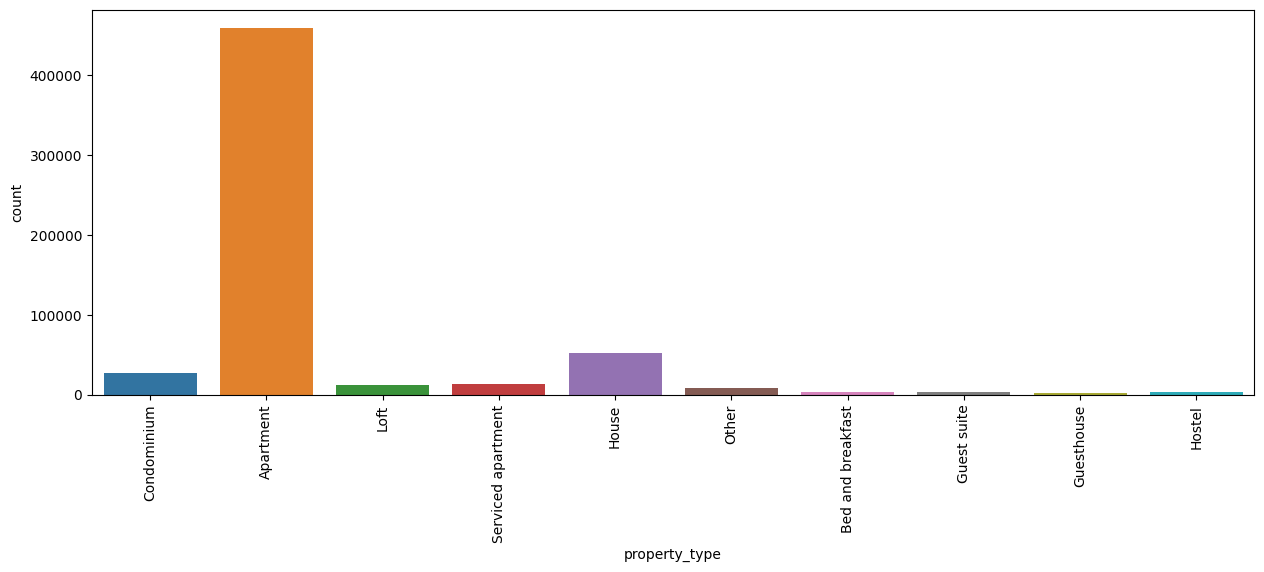

In [44]:
tabela_tipo_imovel = bases_airbnb['property_type'].value_counts()

colunas_agrupar = []

for tipo in tabela_tipo_imovel.index:
    if tabela_tipo_imovel[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    bases_airbnb.loc[bases_airbnb['property_type']==tipo, 'property_type'] = 'Other'

print(bases_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='property_type', data=bases_airbnb, hue='property_type')
grafico.tick_params(axis='x', rotation=90)

In [45]:
bases_airbnb['amenities'].value_counts()

amenities
{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   6012
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom",Washer}                                                                                                                         

### Conforme exposto supra, a coluna de amenities descreve diferentes tipos de comodidades que os locadores especificam nos anúncios,

e não seguem um padrão estrito, conforme nota-se pelas strings, muitas vezes repetidas e com grafias diferentes.

Nesse sentido, mudaremos as amenities pela quantidade total de amenities (comodidades) descritas, a fim de que o modelo leve em consideração, tanto o número dessas últimas, como a preocupação dos detalhes do anúncio. 
Utiliza-se separador "," para fazer a soma.

In [46]:
# print(bases_airbnb['amenities'].iloc[1])
# {TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,
#  "Buzzer/wireless intercom","Family/kid friendly",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}


bases_airbnb['n_amenities'] = bases_airbnb['amenities'].str.split(',').apply(len)

# A primeira parte divide os valores na coluna amenities em listas de strings. 

# Cada valor na coluna amenities é uma string que contém várias comodidades separadas por vírgulas. 

# Após dividir as strings em listas de comodidades, o método apply(len) é usado para calcular o comprimento de cada lista 
# ou seja, contar o número de comodidades para cada entrada.

# droppando a coluna antiga, não mais necessária:

bases_airbnb = bases_airbnb.drop('amenities', axis=1)
bases_airbnb.shape

# excluindo outliers da nova coluna "n_amenities"

bases_airbnb, linhas_removidas = remover_limites(bases_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


C:\Users\Marcio\AppData\Local\Temp\ipykernel_38324\2249992229.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.countplot(x='room_type', data=bases_airbnb, hue_order='bases_airbnb', palette='flare')


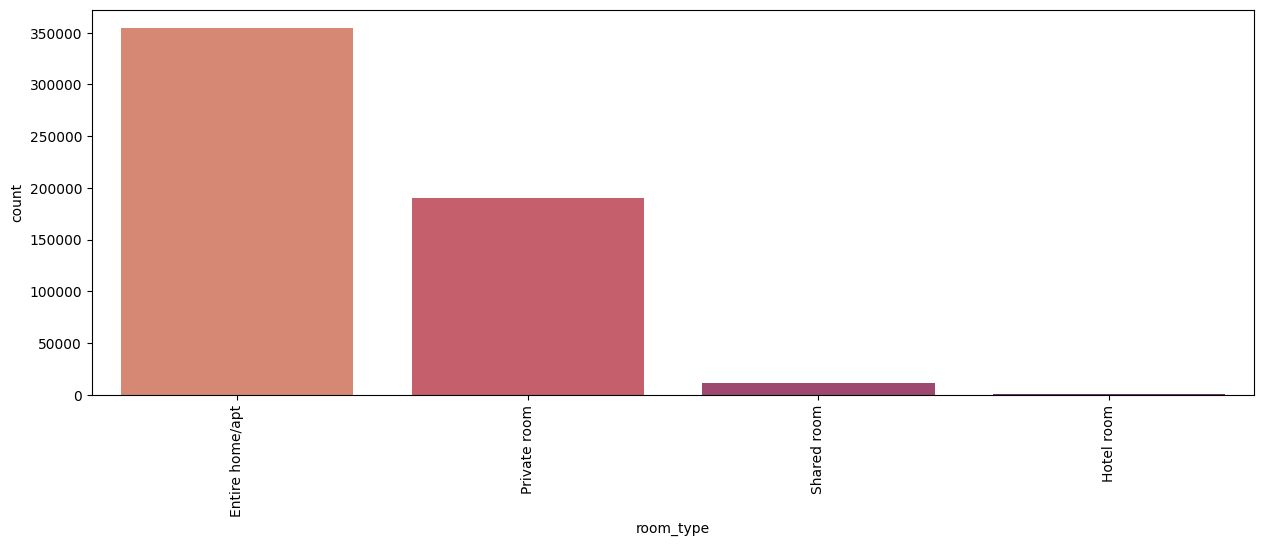

In [47]:
# Do gráfico abaixo nota-se haver uma distribuição equilibrada nos tipos de quartos, não sendo necessário nenhum tratamento adicional 

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='room_type', data=bases_airbnb, hue_order='bases_airbnb', palette='flare')
grafico.tick_params(axis='x', rotation=90)


### Criando visualização de mapa 
#### Observa-se que naturalmente os imóveis localizados na zona sul, parte da barra da tijuca e próximos a vila olímpica, possuem maior densidade de valor:

In [48]:
# utilizaremos uma amostra de 5 mil dados apenas, para dar mais agilidade

amostra = bases_airbnb.sample(n=50000)

centro_mapa = {'lat': amostra['latitude'].mean(), 'lon': amostra['longitude'].mean()}

    # Criar o mapa de densidade
mapa = px.density_mapbox(
        amostra,
        lat='latitude',
        lon='longitude',
        z='price',
        radius=2.5,
        center=centro_mapa,
        zoom=10,
        mapbox_style='open-street-map'  # Estilo padrão do Plotly
    )
    # Mostrar o mapa
mapa.show()

#### Plotaremos o mapa analisando agora o número de comodidades descritos na coluna que criamos anteriormente "n_amenities"

In [49]:
centro_mapa = {'lat': amostra['latitude'].mean(), 'lon': amostra['longitude'].mean()}

    # Criar o mapa de densidade
mapa = px.density_mapbox(
        amostra,
        lat='latitude',
        lon='longitude',
        z='n_amenities',
        radius=2.5,
        center=centro_mapa,
        zoom=10,
        mapbox_style='open-street-map'  # Estilo padrão do Plotly
    )
    # Mostrar o mapa
mapa.show()

### ENCODING
#### Vamos codificar as colunas que possuem valores booleanos (true ou false) e mudá-las para 1 (true) e 0 (false)

In [50]:
colunas_tf = ['host_is_superhost', 'instant_bookable']
base_airbnb_cod = bases_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0


Utilizando a função get_dummies do pandas para adptar as demais colunas categóricas para o aprendizado da máquina:

In [51]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(base_airbnb_cod, columns=colunas_categorias)


### Etapa de construção do modelo

Elegendo as métricas de avaliação de modelo:
* R2 score 
* mean squared error (MSE)

In [52]:
# Definindo função para avaliar através das métricas supra: 
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RMSE = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Nome modelo: {nome_modelo} \nr2: {r2:.2%} \nRMSE: {RMSE:.2f}'

Criando variável para aplicação dos modelos: 

In [53]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor() 

modelos = {'Random forest': modelo_rf,
           'Linear regression': modelo_lr,
            'Extra tree': modelo_et,
            }

In [54]:
y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=40)

In [55]:
%%time

# utilizaremos a função %%time para saber quanto tempo nossos modelos levarão para rodar

for nome_modelo, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Nome modelo: Random forest 
r2: 96.78% 
RMSE: 47.56
Nome modelo: Linear regression 
r2: 33.27% 
RMSE: 216.39
Nome modelo: Extra tree 
r2: 97.41% 
RMSE: 42.61
CPU times: total: 9min 25s
Wall time: 9min 25s


Diante da melhor performance do modelo de extra tree em ambas métricas de avaliação utilizadas, 
assim como a insignificante diferença de tempo de processamento seguiremos, 
elegemos este como melhor modelo para o presente caso, e daremos continuidade no tratamento deste modelo para melhorar ainda mais nossos resultados.

In [56]:
# Observaremos a relevância de cada coluna do nosso modelo escolhido, e após criaremos um novo DF para para avaliar quais 
# features podemos excluir sem prejuízo da qualidade do modelo

relevancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
relevancia_features = relevancia_features.sort_values(by=0, ascending=False)
display(relevancia_features)


0
bedrooms                                         0.117679
latitude                                         0.091694
longitude                                        0.086263
extra_people                                     0.085312
n_amenities                                      0.074016
accommodates                                     0.069174
number_of_reviews                                0.066809
bathrooms                                        0.066438
room_type_Entire home/apt                        0.064067
minimum_nights                                   0.061829
beds                                             0.046694
host_listings_count                              0.036459
instant_bookable                                 0.020816
cancellation_policy_flexible                     0.018690
property_type_Apartment                          0.012613
cancellation_policy_moderate                     0.012160
host_is_superhost                                0.011242
ano                                              0.010651
cancellation_policy_strict_14_with_grace_period  0.008700
property_type_House                              0.006650
property_type_Condominium                        0.004951
mes                                              0.004391
room_type_Private room                           0.003681
bed_type_Pull-out Sofa                           0.002222
property_type_Loft                               0.002188
property_type_Serviced apartment                 0.002169
property_type_Other                              0.002161
bed_type_Real Bed                                0.001993
room_type_Shared room                            0.001908
property_type_Bed and breakfast                  0.001387
property_type_Guesthouse                         0.000902
cancellation_policy_strict                       0.000809
bed_type_Futon                                   0.000712
property_type_Guest suite                        0.000632
property_type_Hostel                             0.000599
bed_type_Couch                                   0.000466
bed_type_Airbed                                  0.000316
room_type_Hotel room                             0.000311
cancellation_policy_super_strict_60              0.000197
cancellation_policy_super_strict_30              0.000047

#### Podemos observar que o gráfico abaixo já nos indica alguns pontos que influenciam drasticamente no preço, quais:
* Quantidade de quartos 
* Localização (sobretudo na zona-sul, barra da tijuca e vila olímpica, conforme análise conjunta no mapa anteriormente plotado)
* Quantidade de pessoas adicionais 
* Quantidade de banheiros 
* Número de comodidades (importante salientar que isso pode se dar tanto pela quantidade de comodidades a mais, 
quanto pelo fato que os locadores que descrevem melhor seus anúncios, conseguem cobrar mais. Essa última análise é subjetiva e requer mais estudo)
* Número de reviews 
* Tipo de imóvel (quarto, apto etc)
* Quantidade de acomodações 
* Mínimo de noites para locação


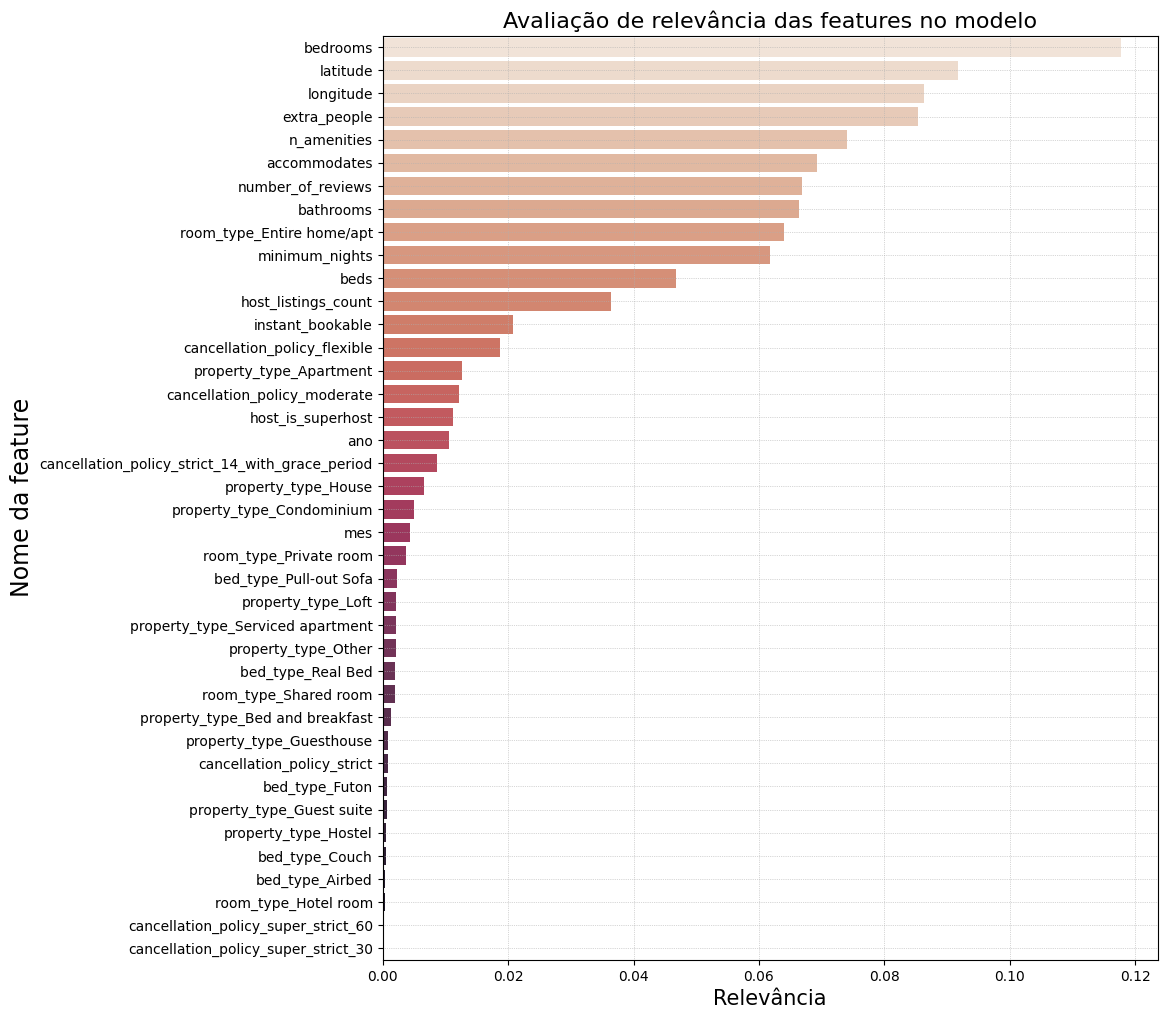

In [57]:
# Plotando gráfico de relevancia das features do modelo para melhor visualização
plt.figure(figsize=(10, 12))
sns.barplot(y=relevancia_features.index, x=relevancia_features[0], hue=relevancia_features.index, palette='rocket_r', saturation=0.6)
plt.title('Avaliação de relevância das features no modelo', fontsize=16)
plt.ylabel('Nome da feature', fontsize=17)
plt.xlabel('Relevância', fontsize=15)
plt.yticks(rotation=0, ha='right')
plt.grid(True, which='both', linestyle=":", linewidth=0.5)
plt.show()

### Agora treinaremos novamente o modelo sem as features 'bed_type' já que ocupam boa parte das features e não representam tanta relevância ao modelo caso haja uma piora significativa na performance do modelo, podemos voltar atrás.
* utilizaremos uma variável teste para isso, para não ser necessário rodar o código inteiro novamente, caso as modificações impliquem em pioras significativas. 

In [58]:
# base_teste = base_airbnb_cod.copy()
# for coluna in base_teste:
#     if 'bed_type' in coluna:    
#         base_teste = base_teste.drop(coluna, axis=1)
# print(base_teste.columns)
# y = base_teste['price']
# X = base_teste.drop('price', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# modelo_et.fit(X_train, y_train)
# previsao = modelo_et.predict(X_test)
# print(avaliar_modelo('ExtraTrees', y_test, previsao))

### Comparemos as diferenças
* Com bed_type:

r2: 97.40% |
RMSE: 42.71

* Sem bed_type:

r2: 97.37% |
RMSE: 42.99

Houvera uma piora em relação ao primeiro modelo, porém dado que a simplicidade e menor quantidade de features é também um ponto positivo, podemos então excluir as features sem prejuízos significantes.

In [59]:
# agora excluiremos 'bed_type' do nosso dataframe original

for coluna in base_airbnb_cod:
    if 'bed_type' in base_airbnb_cod:    
        bases_airbnb = base_airbnb_cod.drop(coluna, axis=1)
print(bases_airbnb.columns)
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'instant_bookable', 'cancellation_policy', 'ano',
       'mes', 'n_amenities'],
      dtype='object')


In [60]:
%%time

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Nome modelo: ExtraTrees 
r2: 97.38% 
RMSE: 42.91
CPU times: total: 4min 37s
Wall time: 4min 37s


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [61]:
X['price'] = y
X.to_csv('dados.csv')

In [62]:
# Utilizando joblib para salvar o modelo
import joblib 
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']